# barc4sr: 
## Example 01 - Photon flux as a function of energy for an ideal and a tabulated undulator

[rafael.celestre@synchrotron-soleil.fr](mailto:rafael.celestre@synchrotron-soleil.fr)

<hr style="border:1px solid orange">


In [1]:
__author__ = ['Rafael Celestre']
__contact__ = 'rafael.celestre@synchrotron-soleil.fr'
__license__ = 'GPL-3.0'
__copyright__ = 'Synchrotron SOLEIL, Saint Aubin, France'
__created__ = '22/03/2024'
__changed__ = '10/04/2024'

import os
import sys

import barc4sr.undulator as und
import numpy as np
from barc4plots.barc4plots import BarcPlotManager
from barc4sr.processing import read_undulator_spectrum
from barc4sr.utils import ElectronBeam, MagneticStructure, write_syned_file

# checking we are using the correct python:
print(sys.executable)
print(sys.version)

# # benchmarking tools
# %load_ext autoreload
# %autoreload 2
# %matplotlib widget

OASYS distribution of SRW
c:\Users\celestre\AppData\Local\miniconda3\envs\oasys\python.exe
3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]


### Creation of SYNED input file (.json)

The SYNED Light Source file containing the electron beam parameters and the undulator parameters 
should be created using [OASYS](https://oasys-kit.github.io/). barc4sr provides a method 
for generating a simplified SYNED file, but the OASYS method remains preferred.

In order to generate the SYNED file, we create an ```ElectronBeam``` object and a ```MagneticStructure```
object and call the ```write_syned_file``` function from ```barc4sr.utils```


In [2]:
eBeam = ElectronBeam()

eBeam.from_twiss(energy=2.75, energy_spread=0.001025, current=0.500,
                 emittance=3.939e-9, coupling=1/100,
                 emittance_x=None, emittance_y=None,
                 beta_x=4.789, beta_y=3.7497, 
                 alpha_x=-0.3858, alpha_y=-0.7746,
                 eta_x=0.1804, eta_y=0.0044,
                 etap_x=0.0007, etap_y=-0.0025)

u64 = MagneticStructure(K_vertical=0.0,
                        K_horizontal=0.0,
                        period_length=64e-3,
                        number_of_periods=28.0)

u64.set_resonant_energy(50, 1, eBeam.energy_in_GeV, "v")

write_syned_file(".\light_sources\soleil_hu64.json", "SOLEIL-HU64", eBeam, u64)

In [3]:
ei = 35
ef = 375
ne = int((ef-ei)/0.1) + 1

## Ideal undulator

### Calculation of the **on-axis** spectrum of an ideal planar undulator

This example show different ways or calling ```xoppy.undulator_spectrum(*args, **kwargs)``` for a filament beam 20m downstream the 
centre of the straight section - no emittance nor energy spread are accounted for here. 

In [4]:
energy, flux = und.undulator_spectrum(file_name=".\example_01\SOLEIL-U64mm_on_axis",
                                  json_file=".\light_sources\soleil_hu64.json",
                                  photon_energy_min=ei,
                                  photon_energy_max=ef,
                                  photon_energy_points=ne,
                                  observation_point=20,
                                  hor_slit=1e-23,
                                  ver_slit=1e-23,
                                  Kv_symmetry=-1,
                                  electron_trajectory=True)

eTraj_ideal = und.read_electron_trajectory(r".\example_01\SOLEIL-U64mm_on_axis_eTraj.dat")
magField = np.asarray([eTraj_ideal["Z"], eTraj_ideal["Bx"], eTraj_ideal["By"], eTraj_ideal["Bz"]]).T
magField = und.generate_srw_magnetic_field(magField, r".\example_01\SOLEIL-U64mm_srw_magField.dat")

Undulator spectrum calculation using SRW. Please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... >>>.\example_01\SOLEIL-U64mm_on_axis_eTraj.dat<<< completed
> Performing on-axis spectrum from filament electron beam ... completed
Undulator spectrum calculation using SRW: finished
>> Total elapsed time: 469.96 ms
>>> saving .\example_01\SOLEIL-U64mm_srw_magField.dat


Calculations for lower harmonics are usually very fast, but when moving away from the undulator regime into
the wiggler regime, calculations slow down. In this case, the calculations could/should be done in parallel:

```python
    energy, flux = und.undulator_spectrum(file_name=".\example_01\SOLEIL-U64mm_on_axis_parallel",
                                    json_file=".\light_sources\soleil_hu64.json",
                                    photon_energy_min=ei,
                                    photon_energy_max=ef,
                                    photon_energy_points=ne,
                                    observation_point=20,
                                    hor_slit=1e-23,
                                    ver_slit=1e-23,
                                    Kv_symmetry=-1,
                                    parallel = True)
```

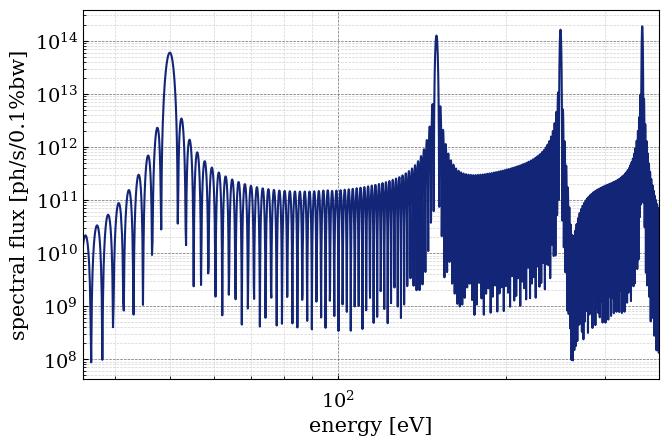

In [5]:
spectrum = read_undulator_spectrum([".\example_01\SOLEIL-U64mm_on_axis_spectrum.pickle"])

img = BarcPlotManager(spectrum["spectrum"]["flux"],  spectrum["spectrum"]["energy"])
img.additional_info(None, "energy [eV]",  "spectral flux [ph/s/0.1%bw]")
img.aesthetics(400, True, True, 3 , 1, True, 4).info_1d_plot(2, None, 1, "-", False, 0, 1).plot_1d(enable=True)

# spectrum_parallel = read_undulator_spectrum([".\example_01\SOLEIL-U64mm_on_axis_parallel_spectrum.pickle"])
# img.image = spectrum_parallel["spectrum"]["flux"]
# img.x = spectrum_parallel["spectrum"]["energy"]
# img.info_1d_plot(3, "parallel", 1, "-", False, 0, 1).plot_1d(enable=False, hold=True)


### Calculation of the on spectrum of an ideal planar undulator **through a slit**

This example show different ways or calling ```xoppy.undulator_spectrum(*args, **kwargs)``` for a slit 20m (100 µrad) downstream the centre of the straight section - emittance and energy spread are taken into account in this calculation


In [6]:
energy, flux = und.undulator_spectrum(file_name=".\example_01\SOLEIL-U64mm_slit",
                                  json_file=".\light_sources\soleil_hu64.json",
                                  photon_energy_min=ei,
                                  photon_energy_max=ef,
                                  photon_energy_points=ne,
                                  observation_point=20,
                                  hor_slit=2e-3,
                                  ver_slit=2e-3,
                                  Kv_symmetry=-1)

Undulator spectrum calculation using SRW. Please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
> Performing flux through finite aperture (simplified partially-coherent simulation)... completed
Undulator spectrum calculation using SRW: finished
>> Total elapsed time: 253.75 ms


Calculations for lower harmonics are usually very fast, but when moving away from the undulator regime into
the wiggler regime, calculations slow down. In this case, the calculations could/should be done in parallel:

```python
energy, flux = und.undulator_spectrum(file_name=".\example_01\SOLEIL-U64mm_slit_par",
                                  json_file=".\light_sources\soleil_hu64.json",
                                  photon_energy_min=ei,
                                  photon_energy_max=ef,
                                  photon_energy_points=ne,
                                  observation_point=20,
                                  hor_slit=2e-3,
                                  ver_slit=2e-3,
                                  Kv_symmetry=-1,
                                  parallel = True)
```

In [7]:
energy, flux = und.undulator_spectrum(file_name=".\example_01\SOLEIL-U64mm_slit_me",
                                  json_file=".\light_sources\soleil_hu64.json",
                                  photon_energy_min=ei,
                                  photon_energy_max=ef,
                                  photon_energy_points=ne,
                                  observation_point=20,
                                  hor_slit=2e-3,
                                  ver_slit=2e-3,
                                  Kv_symmetry=-1,
                                  number_macro_electrons = 1000,
                                  parallel = True)

Undulator spectrum calculation using SRW. Please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
> Performing flux through finite aperture (accurate partially-coherent simulation) in parallel... 
>>> ellapse time:
 Core 1: 59.45 s for 284 pts (E0 = 35.0 eV).
 Core 2: 62.80 s for 283 pts (E0 = 63.4 eV).
 Core 3: 66.40 s for 283 pts (E0 = 91.7 eV).
 Core 4: 67.76 s for 284 pts (E0 = 120.0 eV).
 Core 5: 64.14 s for 283 pts (E0 = 148.4 eV).
 Core 6: 71.50 s for 283 pts (E0 = 176.7 eV).
 Core 7: 72.88 s for 284 pts (E0 = 205.0 eV).
 Core 8: 71.90 s for 283 pts (E0 = 233.4 eV).
 Core 9: 79.82 s for 283 pts (E0 = 261.7 eV).
 Core 10: 74.07 s for 284 pts (E0 = 290.0 eV).
 Core 11: 80.10 s for 283 pts (E0 = 318.4 eV).
 Core 12: 80.13 s for 284 pts (E0 = 346.7 eV).
completed
Undulator spectrum calculation using SRW: finished
>> Total elapsed time: 1 min 21.66 s


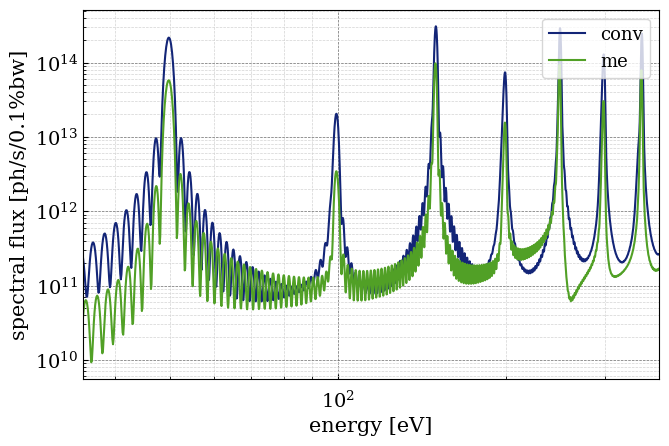

In [8]:
spectrum = read_undulator_spectrum([".\example_01\SOLEIL-U64mm_slit_spectrum.pickle"])
img = BarcPlotManager(spectrum["spectrum"]["flux"],  spectrum["spectrum"]["energy"])
img.additional_info(None, "energy [eV]",  "spectral flux [ph/s/0.1%bw]")
img.aesthetics(400, True, True, 3 , 1, True, 4).info_1d_plot(2, 'conv', 0, "-", False, 0, 1).plot_1d(enable=False)

spectrum_parallel = read_undulator_spectrum([".\example_01\SOLEIL-U64mm_slit_me_spectrum.pickle"])
img.image = spectrum_parallel["spectrum"]["flux"]
img.x = spectrum_parallel["spectrum"]["energy"]
img.info_1d_plot(3, "me", 1, "-", False, 0, 1).plot_1d(enable=True, hold=True)


## Tabulated undulator

### Calculation of the **on-axis** spectrum of a tabulated planar undulator

This example show different ways or calling ```xoppy.undulator_spectrum(*args, **kwargs)``` for a filament beam 20m downstream the 
centre of the straight section - no emittance nor energy spread are accounted for here. 


In [9]:
energy, flux = und.undulator_spectrum(file_name=".\example_01\SOLEIL-tabU64mm_on_axis",
                                  json_file=".\light_sources\soleil_hu64.json",
                                  photon_energy_min=ei,
                                  photon_energy_max=ef,
                                  photon_energy_points=ne,
                                  observation_point=20,
                                  hor_slit=1e-23,
                                  ver_slit=1e-23,
                                  Kv_symmetry=-1,
                                  electron_trajectory=True,
                                  magnetic_measurement=r".\light_sources\tabulated_hu64.dat")

eTraj_ideal = und.read_electron_trajectory(r".\example_01\SOLEIL-tabU64mm_on_axis_eTraj.dat")
magField = np.asarray([eTraj_ideal["Z"], eTraj_ideal["Bx"], eTraj_ideal["By"], eTraj_ideal["Bz"]]).T
magField = und.generate_srw_magnetic_field(magField, r".\example_01\SOLEIL-tabU64mm_srw_magField.dat")

Undulator spectrum calculation using SRW. Please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ...  tabulated magnetic field ... completed
> Electron trajectory calculation ... >>>.\example_01\SOLEIL-tabU64mm_on_axis_eTraj.dat<<< completed
> Performing on-axis spectrum from filament electron beam ... completed
Undulator spectrum calculation using SRW: finished
>> Total elapsed time: 449.08 ms
>>> saving .\example_01\SOLEIL-tabU64mm_srw_magField.dat


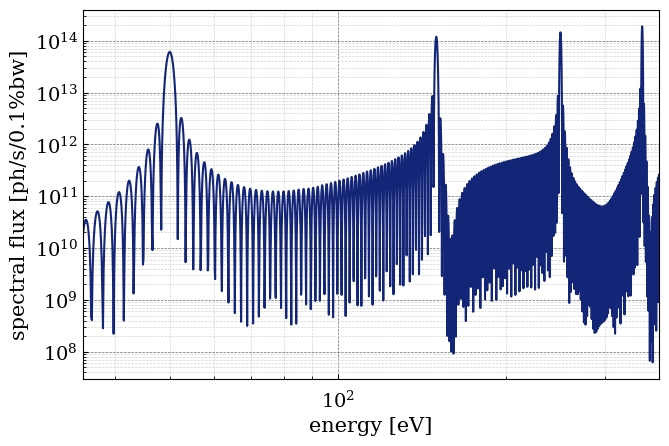

In [10]:
spectrum = read_undulator_spectrum([".\example_01\SOLEIL-tabU64mm_on_axis_spectrum.pickle"])

img = BarcPlotManager(spectrum["spectrum"]["flux"],  spectrum["spectrum"]["energy"])
img.additional_info(None, "energy [eV]",  "spectral flux [ph/s/0.1%bw]")
img.aesthetics(400, True, True, 3 , 1, True, 4).info_1d_plot(2, None, 1, "-", False, 0, 1).plot_1d(enable=True)

### Calculation of the on spectrum of an tabulated planar undulator **through a slit**

This example show different ways or calling ```xoppy.undulator_spectrum(*args, **kwargs)``` for a slit 20m (100 µrad) downstream the centre of the straight section - emittance and energy spread are taken into account in this calculation

In [11]:
energy, flux = und.undulator_spectrum(file_name=".\example_01\SOLEIL-tabU64mm_slit_me",
                                  json_file=".\light_sources\soleil_hu64.json",
                                  photon_energy_min=ei,
                                  photon_energy_max=ef,
                                  photon_energy_points=ne,
                                  observation_point=20,
                                  hor_slit=2e-3,
                                  ver_slit=2e-3,
                                  Kv_symmetry=-1,
                                  magnetic_measurement=r".\light_sources\tabulated_hu64.dat",
                                  number_macro_electrons = 1000,
                                  parallel = True,
                                  )

Undulator spectrum calculation using SRW. Please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ...  tabulated magnetic field ... completed
> Electron trajectory calculation ... completed
> Performing flux through finite aperture (accurate partially-coherent simulation) in parallel... 
>>> ellapse time:
 Core 1: 62.23 s for 284 pts (E0 = 35.0 eV).
 Core 2: 67.92 s for 283 pts (E0 = 63.4 eV).
 Core 3: 68.13 s for 283 pts (E0 = 91.7 eV).
 Core 4: 72.15 s for 284 pts (E0 = 120.0 eV).
 Core 5: 68.20 s for 283 pts (E0 = 148.4 eV).
 Core 6: 75.06 s for 283 pts (E0 = 176.7 eV).
 Core 7: 81.51 s for 284 pts (E0 = 205.0 eV).
 Core 8: 77.99 s for 283 pts (E0 = 233.4 eV).
 Core 9: 83.69 s for 283 pts (E0 = 261.7 eV).
 Core 10: 79.67 s for 284 pts (E0 = 290.0 eV).
 Core 11: 85.77 s for 283 pts (E0 = 318.4 eV).
 Core 12: 85.66 s for 284 pts (E0 = 346.7 eV).
completed
Undulator spectrum calculation using SRW: finished
>> Total elapsed time: 1 min 25.83 s


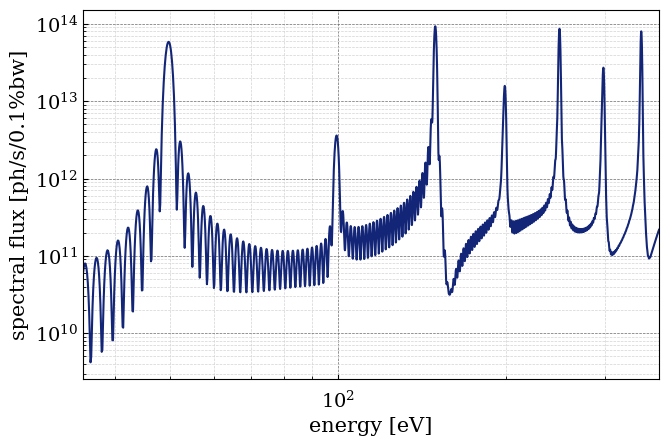

In [12]:
spectrum = read_undulator_spectrum([".\example_01\SOLEIL-tabU64mm_slit_me_spectrum.pickle"])

img = BarcPlotManager(spectrum["spectrum"]["flux"],  spectrum["spectrum"]["energy"])
img.additional_info(None, "energy [eV]",  "spectral flux [ph/s/0.1%bw]")
img.aesthetics(400, True, True, 3 , 1, True, 4).info_1d_plot(2, None, 1, "-", False, 0, 1).plot_1d(enable=True)

## Comparison between the ideal and tabulated undulators

### On axis flux

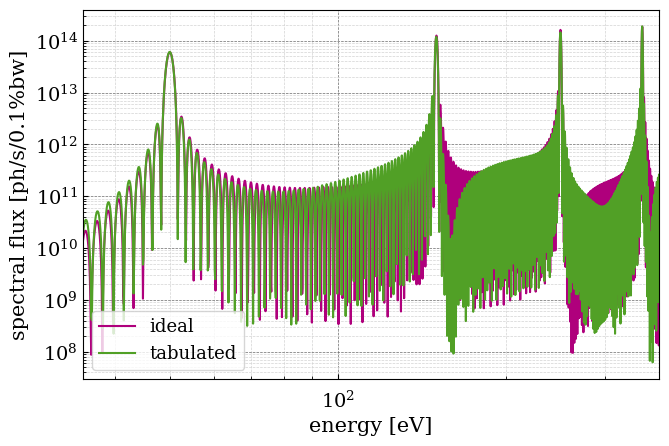

In [13]:
spectrum = read_undulator_spectrum([".\example_01\SOLEIL-U64mm_on_axis_spectrum.pickle"])
img = BarcPlotManager(spectrum["spectrum"]["flux"],  spectrum["spectrum"]["energy"])
img.additional_info(None, "energy [eV]",  "spectral flux [ph/s/0.1%bw]")
img.aesthetics(400, True, True, 3 , 1, True, 2)
img.info_1d_plot(4, "ideal", 0, '-', False, 0, 1).plot_1d(enable=False, hold=False)
spectrum = read_undulator_spectrum([".\example_01\SOLEIL-tabU64mm_on_axis_spectrum.pickle"])
img.image = spectrum["spectrum"]["flux"]
img.x = spectrum["spectrum"]["energy"]
img.info_1d_plot(3, "tabulated", 0, '-', False, 0, 1).plot_1d(enable=True, hold=True)

### Flux through a slit

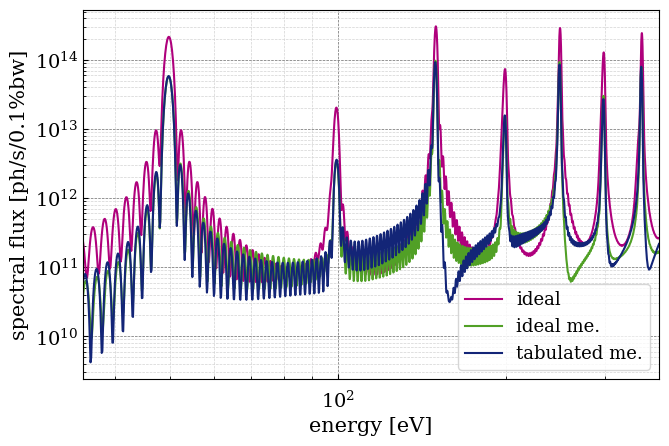

In [14]:
spectrum = read_undulator_spectrum([".\example_01\SOLEIL-U64mm_slit_spectrum.pickle"])
img = BarcPlotManager(spectrum["spectrum"]["flux"],  spectrum["spectrum"]["energy"])
img.additional_info(None, "energy [eV]",  "spectral flux [ph/s/0.1%bw]")
img.aesthetics(400, True, True, 3 , 1, True, 2)
img.info_1d_plot(4, "ideal", 0, '-', False, 0, 1).plot_1d(enable=False, hold=False)
spectrum = read_undulator_spectrum([".\example_01\SOLEIL-U64mm_slit_me_spectrum.pickle"])
img.image = spectrum["spectrum"]["flux"]
img.x = spectrum["spectrum"]["energy"]
img.info_1d_plot(3, "ideal me.", 0, '-', False, 0, 1).plot_1d(enable=False, hold=True)
spectrum = read_undulator_spectrum([".\example_01\SOLEIL-tabU64mm_slit_me_spectrum.pickle"])
img.image = spectrum["spectrum"]["flux"]
img.x = spectrum["spectrum"]["energy"]
img.info_1d_plot(2, "tabulated me.", 0, '-', False, 0, 1).plot_1d(enable=True, hold=True)

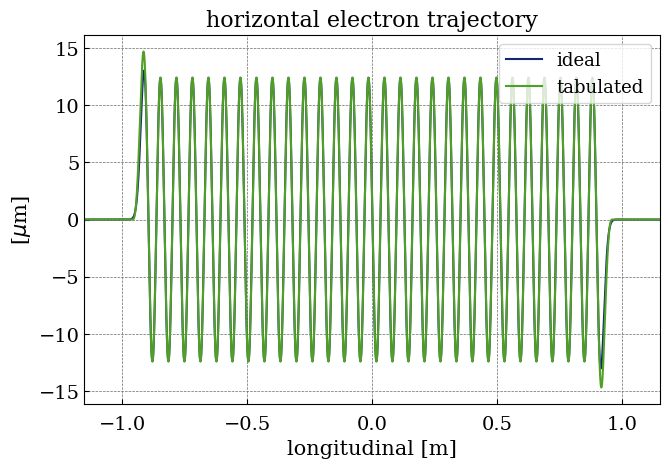

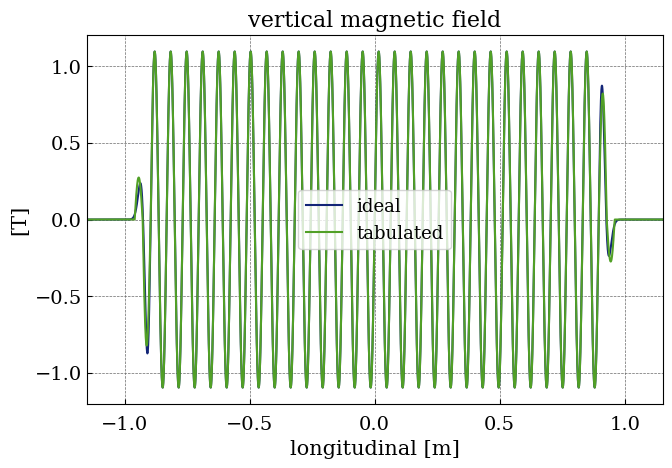

In [15]:
eTraj_ideal = und.read_electron_trajectory(r".\example_01\SOLEIL-U64mm_on_axis_eTraj.dat")
eTraj_meas = und.read_electron_trajectory(r".\example_01\SOLEIL-tabU64mm_on_axis_eTraj.dat")

img = BarcPlotManager(eTraj_ideal["X"]*1E6, eTraj_ideal["Z"])
img.additional_info("horizontal electron trajectory", "longitudinal [m]", "[$\mu$m]")
img.aesthetics(400, True, True, 0 , 1, True, 2)
img.info_1d_plot(2, "ideal", 0, '-', False, 0, 1).plot_1d(enable=False, hold=False)
img.image = eTraj_meas["X"]*1E6
img.x = eTraj_meas["Z"]
img.info_1d_plot(3, "tabulated", 0, '-', False, 0, 1).plot_1d(enable=True, hold=True)

img = BarcPlotManager(eTraj_ideal["By"], eTraj_ideal["Z"])
img.additional_info("vertical magnetic field", "longitudinal [m]", "[T]")
img.aesthetics(400, True, True, 0 , 1, True, 2)
img.info_1d_plot(2, "ideal", 0, '-', False, 0, 1).plot_1d(enable=False, hold=False)
img.image = eTraj_meas["By"]
img.x = eTraj_meas["Z"]
img.info_1d_plot(3, "tabulated", 0, '-', False, 0, 1).plot_1d(enable=True, hold=True)